In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.animation as animation

from torch.utils.data import Dataset
# import binvox
import os
import json
import trimesh
import skimage
import random
# from mesh_to_sdf import mesh_to_voxels, sample_sdf_near_surface, scale_to_unit_sphere
import mesh_to_sdf
import pyrender
import numpy as np
import matplotlib.pyplot as plt
import io
from deep_sdf import utils, metrics, plotting, workspace
import math
import pandas as pd
import pytorch3d
import sklearn
from sklearn.manifold import TSNE
import torch
import matplotlib
import copy
import shlex

import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

/home/wulff/anaconda3/envs/deep3dcomp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


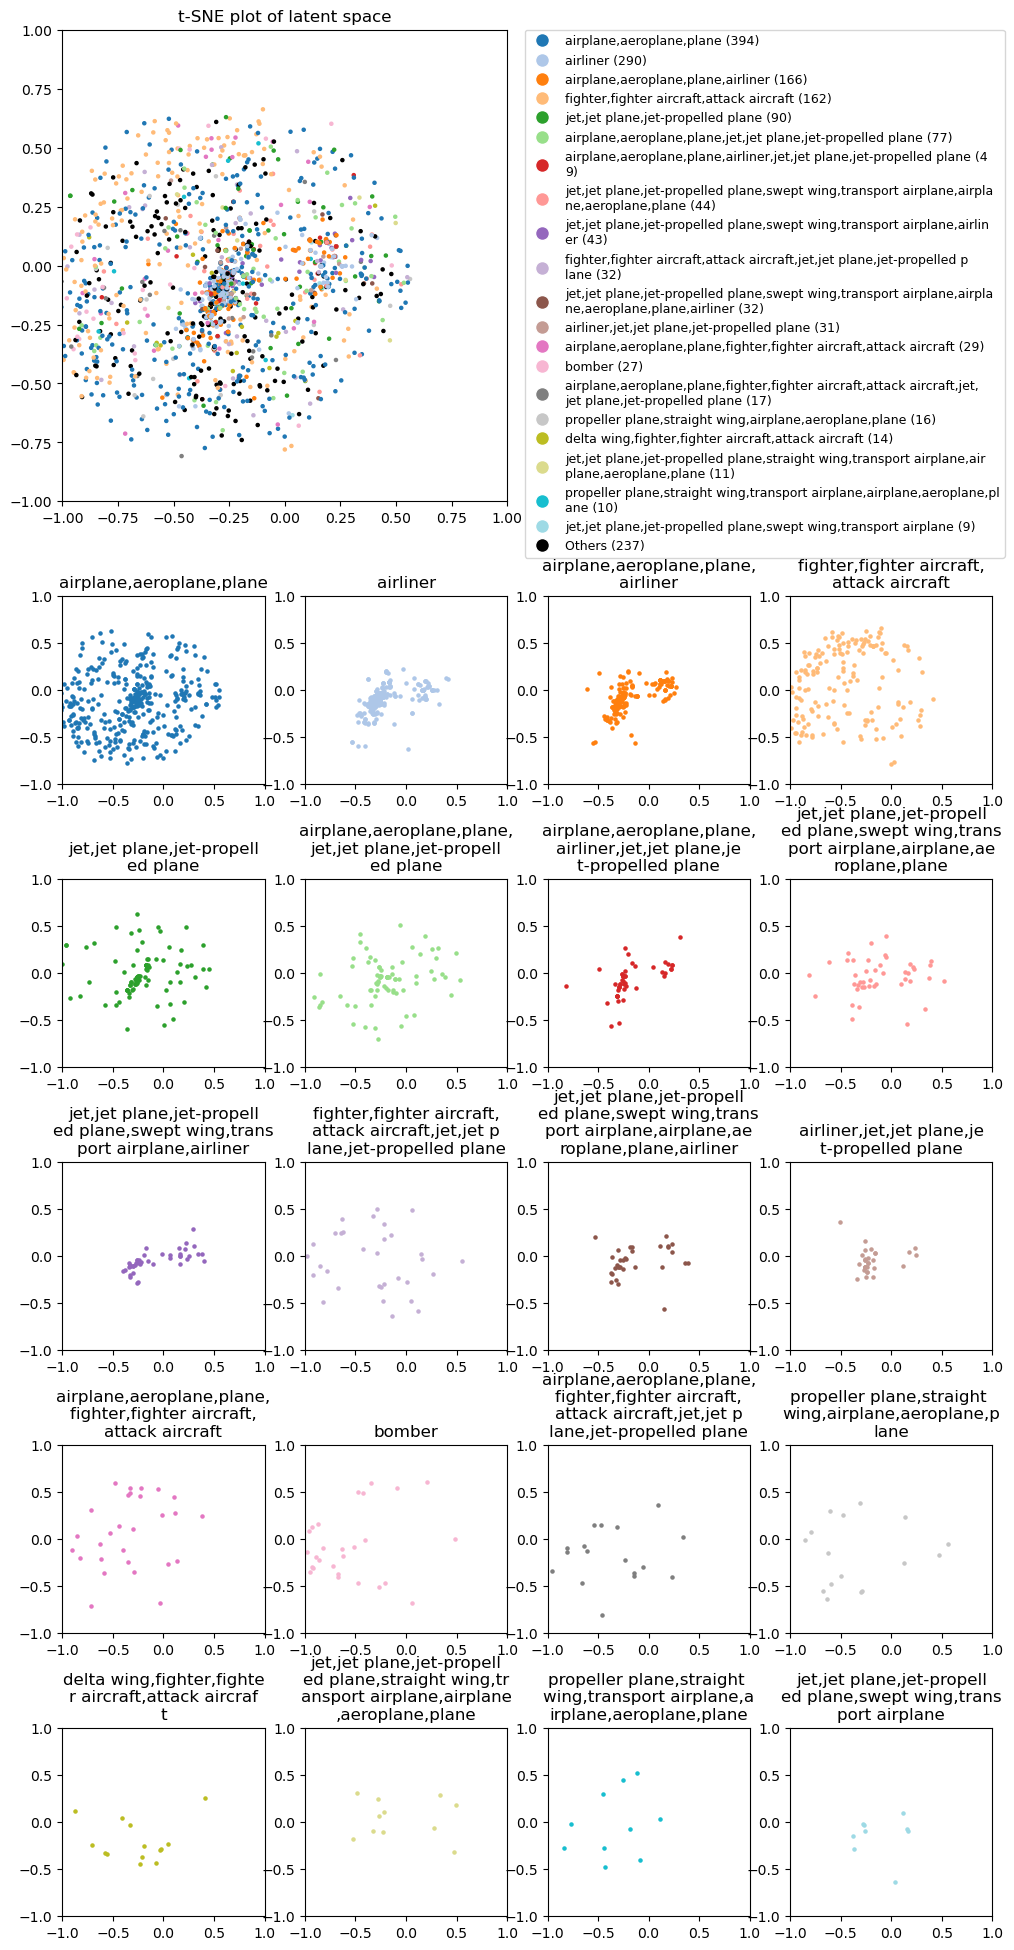

In [6]:
plotting.plot_manifold_tsne("../../shared/deepsdfcomp/searches/num_shapes_search/all_shapes_batch_size_128/")

117.96296296296296
106.44565217391305
112.26086956521739
105.52604166666667
102.68325791855203
102.8


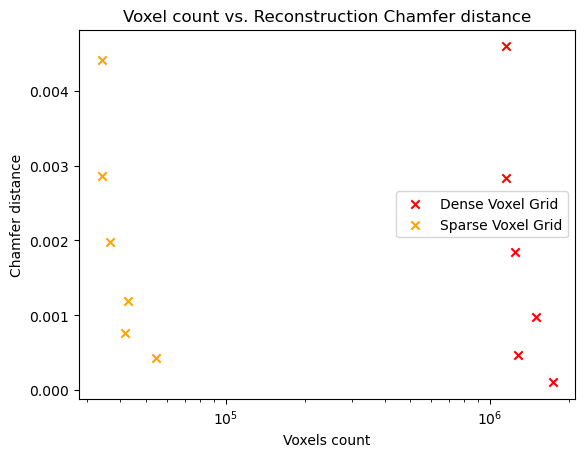

In [175]:
# exps = [
#     "../../shared/deepsdfcomp/size_vs_performance/siren_width=64_no_bottleneck/",
#     "../../shared/deepsdfcomp/size_vs_performance/siren_width=128_no_bottleneck/",
#     "../../shared/deepsdfcomp/size_vs_performance/siren_width=256_no_bottleneck/",
#     ]
vox_logs = [
    "data/voxelize_until_cd_meshes_CD=0.0001/run_voxelize_until_CD_logs.csv",
    "data/voxelize_until_cd_meshes_CD=0.0005/run_voxelize_until_CD_logs.csv",
    "data/voxelize_until_cd_meshes_CD=0.001/run_voxelize_until_CD_logs.csv",
    "data/voxelize_until_cd_meshes_CD=0.002/run_voxelize_until_CD_logs.csv",
    "data/voxelize_until_cd_meshes_CD=0.003/run_voxelize_until_CD_logs.csv",
    "data/voxelize_until_cd_meshes_CD=0.005/run_voxelize_until_CD_logs.csv",
]
plotting.plot_capacity_vs_chamfer_dist(voxelization_logs=vox_logs)

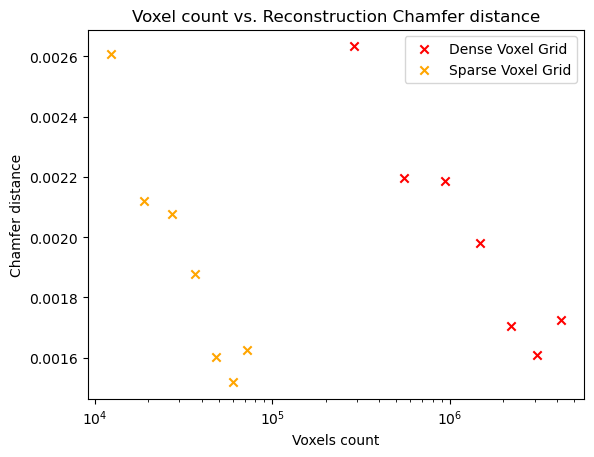

In [3]:
# exps = [
#     "../../shared/deepsdfcomp/size_vs_performance/siren_width=64_no_bottleneck/",
#     "../../shared/deepsdfcomp/size_vs_performance/siren_width=128_no_bottleneck/",
#     "../../shared/deepsdfcomp/size_vs_performance/siren_width=256_no_bottleneck/",
#     ]
vox_logs = [
    "data/voxRes/voxelize_meshes_res=64/run_voxelize_logs.csv",
    "data/voxRes/voxelize_meshes_res=80/run_voxelize_logs.csv",
    "data/voxRes/voxelize_meshes_res=96/run_voxelize_logs.csv",
    "data/voxRes/voxelize_meshes_res=112/run_voxelize_logs.csv",
    "data/voxRes/voxelize_meshes_res=128/run_voxelize_logs.csv",
    "data/voxRes/voxelize_meshes_res=144/run_voxelize_logs.csv",
    "data/voxRes/voxelize_meshes_res=160/run_voxelize_logs.csv",
    # "data/voxRes/voxelize_meshes_res=176/run_voxelize_logs.csv",
    # "data/voxRes/voxelize_meshes_res=192/run_voxelize_logs.csv",
    # "data/voxRes/voxelize_meshes_res=112/run_voxelize.csv",
    # "data/voxRes/voxelize_meshes_res=118/run_voxelize_until_CD_logs.csv",
]
plotting.plot_capacity_vs_chamfer_dist(voxelization_logs=vox_logs)

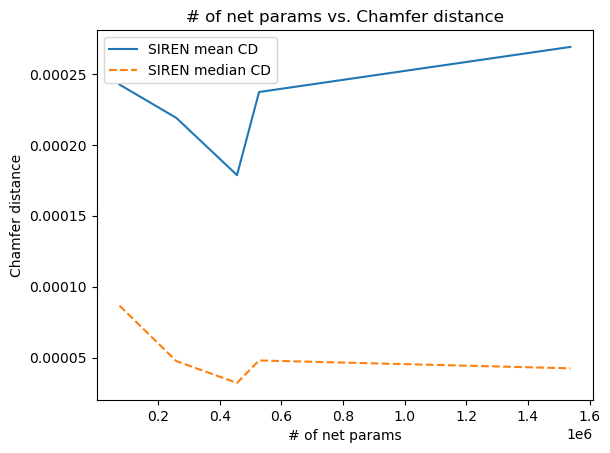

In [22]:
exps = [
    "../../shared/deepsdfcomp/searches/num_params_search/exp00_4layers_128width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp01_6layers_192width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp04_12layers_384width",
    "../../shared/deepsdfcomp/searches/num_params_search/exp05_6layers_288width",
    "../../shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule",
    # "../../shared/deepsdfcomp/searches/num_params_search/",
    # "../../shared/deepsdfcomp/searches/num_params_search/",
    ]
vox_logs = [
    
]
plotting.plot_capacity_vs_chamfer_dist(exp_dirs_net_capacity=exps)

In [16]:
mesh.dump().sum().vertices

TrackedArray([[-8.00000e-06,  5.50200e-03, -2.32190e-01],
              [ 6.16000e-04,  5.50800e-03, -2.32034e-01],
              [ 6.16000e-04,  1.85930e-02, -2.24949e-01],
              ...,
              [ 2.70702e-01,  5.03380e-02,  1.02943e-01],
              [ 2.48940e-02,  5.45030e-02,  1.14542e-01],
              [ 2.48940e-02,  5.45030e-02,  1.14542e-01]])

In [25]:
utils.rescale_unit_mesh(mesh_u, centroid, scale).bounding_box.volume

0.12006992172289159

In [35]:
mesh = trimesh.load("/mnt/hdd/ShapeNetCore.v2/02691156/d3b9114df1d8a3388e415c6cf89025f0/models/model_normalized.obj")
mesh = utils.as_mesh(mesh)
print(mesh.bounding_box.volume)
mesh_u, centroid, scale = utils.scale_to_unit_sphere(mesh, return_stats=True)
print(mesh_u.bounding_box.volume)
vertices = mesh_u.vertices * scale + centroid
reconstruction = trimesh.Trimesh(vertices=vertices, faces=mesh_u.faces)
print(reconstruction.bounding_box.volume)

0.12006992172289159
1.7405331816868594
1.7405331816868594


In [4]:
voxel_resolution = 64
gt_mesh = utils.as_mesh(trimesh.load("/mnt/hdd/ShapeNetCore.v2/02691156/d3b9114df1d8a3388e415c6cf89025f0/models/model_normalized.obj"))
# gt_mesh = utils.as_mesh(trimesh.load("/mnt/hdd/ShapeNetCore.v2/02691156/d3d788c1fb35227619ba010ddb4974fe/models/model_normalized.obj"))
print(gt_mesh.bounding_box.centroid)
gt_mesh_unit, gt_centroid, gt_scale = utils.scale_to_unit_cube(gt_mesh, return_stats=True)

voxel_size = 2.0 / (voxel_resolution - 1)

voxels = mesh_to_sdf.mesh_to_voxels(gt_mesh_unit, voxel_resolution=voxel_resolution, check_result=True, pad=True, sign_method="depth")
verts, faces, normals, _ = skimage.measure.marching_cubes(voxels, level=0.0, spacing=[voxel_size] * 3, method="lewiner")
reconstruction_unit = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
# reconstruction = utils.rescale_unit_mesh(reconstruction_unit, gt_centroid, gt_scale)
vertices = reconstruction_unit.vertices * gt_scale + gt_centroid 
reconstruction = trimesh.Trimesh(vertices=vertices, faces=reconstruction_unit.faces)
cd, _ = metrics.compute_metric(gt_mesh, reconstruction, metric="chamfer")
print(cd)

[-8.0000e-06  6.0181e-02  1.9860e-02]
0.10868083760445263


In [10]:
voxel_resolution = 64
gt_mesh = utils.as_mesh(trimesh.load("/mnt/hdd/ShapeNetCore.v2/02691156/d3b9114df1d8a3388e415c6cf89025f0/models/model_normalized.obj"))
gt_mesh_unit, gt_centroid, gt_scale = utils.scale_to_unit_cube(gt_mesh, return_stats=True)

voxel_size = 2.0 / (voxel_resolution - 1)

# Extract voxel grid.
voxels = mesh_to_sdf.mesh_to_voxels(gt_mesh_unit, voxel_resolution=voxel_resolution, check_result=True, pad=True, sign_method="depth")
# Reconstruct mesh from voxel grid.
verts, faces, normals, _ = skimage.measure.marching_cubes(voxels, level=0.0, spacing=[voxel_size] * 3, method="lewiner")
reconstruction_unit = utils.scale_to_unit_cube(trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals))
# Rescale.
reconstruction = utils.rescale_unit_mesh(reconstruction_unit, gt_centroid, gt_scale)
# Compute reconstruction quality.
cd, _ = metrics.compute_metric(gt_mesh, reconstruction, metric="chamfer")
print(cd)

0.0058233627056159115


In [9]:
# gt_mesh = utils.as_mesh(trimesh.load("/mnt/hdd/ShapeNetCore.v2/02691156/d3b9114df1d8a3388e415c6cf89025f0/models/model_normalized.obj"))
# reconstruction = trimesh.load("/home/wulff/deepsdf/data/voxRes/voxelize_meshes_res=64/02691156/d3b9114df1d8a3388e415c6cf89025f0.ply")

yourList = [gt_mesh_unit, reconstruction_unit]
vertice_list = [mesh.vertices for mesh in yourList]
faces_list = [mesh.faces for mesh in yourList]
faces_offset = np.cumsum([v.shape[0] for v in vertice_list])
faces_offset = np.insert(faces_offset, 0, 0)[:-1]

vertices = np.vstack(vertice_list)
faces = np.vstack([face + offset for face, offset in zip(faces_list, faces_offset)])
print(abs(yourList[0].bounding_box.centroid-yourList[1].bounding_box.centroid))

merged__meshes = trimesh.Trimesh(vertices, faces)
merged__meshes.show()

[1.03170395 0.87394275 1.14431772]


In [6]:
gt_mesh = utils.as_mesh(trimesh.load("/mnt/hdd/ShapeNetCore.v2/02691156/d3b9114df1d8a3388e415c6cf89025f0/models/model_normalized.obj"))
gt_mesh_unit, gt_centroid, gt_scale = utils.scale_to_unit_cube(gt_mesh, return_stats=True)
reconstruction = utils.rescale_unit_mesh(gt_mesh_unit, gt_centroid, gt_scale)
cd, _ = metrics.compute_metric(gt_mesh, reconstruction, metric="chamfer")
print(cd)

1.200784625130049e-05


In [8]:
gt_mesh_unit.bounding_box.centroid, np.max(gt_mesh_unit.bounding_box.extents)

(array([ 2.0660146e-17, -1.0330073e-17,  1.0330073e-17]), 1.9999999999999998)

In [14]:
mesh_u.vertices * scale + centroid

TrackedArray([[-8.00000e-06,  5.50200e-03, -2.32190e-01],
              [ 6.16000e-04,  5.50800e-03, -2.32034e-01],
              [ 6.16000e-04,  1.85930e-02, -2.24949e-01],
              ...,
              [-1.71670e-02,  1.33271e-01,  3.81784e-01],
              [-1.71670e-02,  1.32718e-01,  3.81784e-01],
              [-1.66510e-02,  1.31058e-01,  3.75957e-01]])

In [9]:
reconstruction = trimesh.load("/home/wulff/deepsdf/data/voxRes/voxelize_meshes_res=64/02691156/d3b9114df1d8a3388e415c6cf89025f0.ply")

In [8]:
reconstruction.bounding_box.vertices, reconstruction.bounding_box.volume

(TrackedArray([[0.12098753, 0.34010431, 0.16461132],
               [0.12098753, 0.34010431, 0.81375647],
               [0.12098753, 0.49822831, 0.16461132],
               [0.12098753, 0.49822831, 0.81375647],
               [0.72526562, 0.34010431, 0.16461132],
               [0.72526562, 0.34010431, 0.81375647],
               [0.72526562, 0.49822831, 0.16461132],
               [0.72526562, 0.49822831, 0.81375647]]),
 0.06202638185049129)

In [10]:
mesh.bounding_box.vertices, mesh.bounding_box.volume

(TrackedArray([[-0.285115, -0.075618, -0.36779 ],
               [-0.285115, -0.075618,  0.40751 ],
               [-0.285115,  0.19598 , -0.36779 ],
               [-0.285115,  0.19598 ,  0.40751 ],
               [ 0.285099, -0.075618, -0.36779 ],
               [ 0.285099, -0.075618,  0.40751 ],
               [ 0.285099,  0.19598 , -0.36779 ],
               [ 0.285099,  0.19598 ,  0.40751 ]]),
 0.12006992172289159)

In [29]:
num_fc_params = 557620
aspect_ratio = 256 / 8
code_length = 200

138

In [12]:
# weigths                       # biases                # last layer
2*200*253 + 6*253*253 + 7*3*253 + 2*200 + 6*253 + 7*3 + 256*1 + 256
# lat       fc          xyz
# should be 557620

493018

In [20]:
pd.read_csv("../../shared/deepsdfcomp/searches/num_shapes_search/1400_shapes_batch_size_128/Evaluation/2000/chamfer.csv", delimiter=";").mean()

/tmp/ipykernel_3023311/2582687240.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.read_csv("../../shared/deepsdfcomp/searches/num_shapes_search/1400_shapes_batch_size_128/Evaluation/2000/chamfer.csv", delimiter=";").mean()


chamfer_dist          0.000268
normal_consistency    0.021097
dtype: float64

In [54]:
from networks.siren_decoder import Decoder

dims = [288] * 6
dims[3] += 200

decoder = Decoder(200, dims, xyz_in_all=True, latent_in=[4])
print(decoder)
param_cnt = 0
for param in decoder.parameters():
    # param_size += param.nelement() * param.element_size()
    param_cnt += param.nelement()    
print(param_cnt)

Decoder(
  (decoder): SirenDecoder(
    (nl): ReLU()
    (lin0): Linear(in_features=203, out_features=285, bias=True)
    (lin1): Linear(in_features=288, out_features=285, bias=True)
    (lin2): Linear(in_features=288, out_features=285, bias=True)
    (lin3): Linear(in_features=288, out_features=285, bias=True)
    (lin4): Linear(in_features=488, out_features=285, bias=True)
    (lin5): Linear(in_features=288, out_features=285, bias=True)
    (lin6): Linear(in_features=288, out_features=1, bias=True)
  )
)
527254


In [40]:
12*256/8

384.0

In [69]:
40/557616 * 3677242

263.7831052193624

In [7]:
df_voxelized.mean(numeric_only=True)

Unnamed: 0.1             68.500000
Unnamed: 0                0.000000
voxel_resolution        112.260870
gt_vertices           83911.528986
decimated_vertices     8289.065217
cd                        0.000973
iteration                 2.318841
dtype: float64

In [13]:
203*253+253 + (256*253+253)*6 + 456*253+253 + 256*1+256

557871

In [16]:
df_siren.sort_values("chamfer_dist", ascending=False).drop(columns=["all_chamfer_dist"])

,shape,chamfer_dist,normal_consistency
412,ShapeNetV2/02691156/fc16704314dc71ee9a6e43b878d5b335,8.756794e-03,0.012752
360,ShapeNetV2/02691156/f6e6fd724a9eab24ba8e93696257b3fc,5.344461e-03,0.016526
438,ShapeNetV2/02691156/fef1c15a5db21b00a67cc8f661e7890a,4.676031e-03,0.015771
153,ShapeNetV2/02691156/df25be12ae47d2517ef7776b3bf5815c,2.579081e-03,0.017206
390,ShapeNetV2/02691156/f9db62e6a88f0d7129343faf3bbffb15,2.484231e-03,0.010837
...,...,...,...
244,ShapeNetV2/02691156/e87902d01d40c71521b1ceea9c93aa79,1.015518e-05,0.017794
16,ShapeNetV2/02691156/d28a3cd771b2bf1e71d03b466c72ce41,9.532152e-06,0.015387
152,ShapeNetV2/02691156/df1c68e94259c6cf5c7319b71bdce6e,7.015172e-06,0.020189
154,ShapeNetV2/02691156/df411aa240fe48d5855eb7906a7a7a04,2.100116e-06,0.016054


In [82]:
L_ = L.toarray()
# Get per-vertex values
v0 = L_[mesh.faces[:, 0], mesh.faces[:, 0]]
v1 = L_[mesh.faces[:, 1], mesh.faces[:, 1]]
v2 = L_[mesh.faces[:, 2], mesh.faces[:, 2]]
faces_v = np.mean([v0, v1, v2], axis=0)
L_.shape, v0.shape, v1.shape, v2.shape, faces_v.shape

((275, 275), (586,), (586,), (586,), (586,))

In [152]:
mesh = trimesh.load("/mnt/hdd/ShapeNetCore.v2/02691156/d068bfa97f8407e423fc69eefd95e6d3/models/model_normalized.obj")
mesh = trimesh.load("../../shared/deepsdfcomp/data/manifold_meshes/02691156/d068bfa97f8407e423fc69eefd95e6d3.obj")

mesh = utils.as_mesh(mesh)
L = trimesh.smoothing.laplacian_calculation(mesh)
L_ = L.tocsr()
# Get the per-vertex Laplacian value
all_vertex_values = []
# Loop through all vertices and their (varying number of) neighbor vertices.
for i, js in enumerate(mesh.vertex_neighbors):
    # Get the Laplacian weights of the [i,j1], [i,j2], ... cells.
    v_vals = L_[i, js]
    all_vertex_values.append(v_vals.mean())
all_vertex_values = np.array(all_vertex_values)
# Aggregate per-vertex values to per-face values.
v0 = all_vertex_values[mesh.faces[:, 0]]
v1 = all_vertex_values[mesh.faces[:, 1]]
v2 = all_vertex_values[mesh.faces[:, 2]]
all_faces_values = np.mean([v0, v1, v2], axis=0)

# Produce face colors from face values and colormap.
cmap_low_to_high = matplotlib.colormaps["plasma"].colors
# Convert to RGBA and scale to [0, 255].
cmap_low_to_high = [[int(_*255) for _ in color] + [255] for color in cmap_low_to_high]
face_colors = list(map(lambda v: cmap_low_to_high[int(v*len(cmap_low_to_high))], all_faces_values))
# RGBA in range [0, 255]. Default is [102, 102, 102, 255].
mesh.visual.face_colors = np.array(face_colors)/255

from scipy import stats
print(stats.describe(all_faces_values))

In [77]:
face_curvatures.shape

(32600, 3)

In [86]:
import trimesh
import numpy as np
import scipy
import igl
import robust_laplacian
# mesh = trimesh.load("/home/freissmuth/deepsdf/suzan.obj")
mesh = trimesh.load("/mnt/hdd/ShapeNetCore.v2/02691156/10155655850468db78d106ce0a280f87/models/model_normalized.obj")
if type(mesh) == trimesh.scene.scene.Scene:
    mesh = trimesh.util.concatenate(mesh.dump())

l, m = robust_laplacian.mesh_laplacian(np.array(mesh.vertices), np.array(mesh.faces))
minv = scipy.sparse.diags(1 / m.diagonal())
Lap = -minv.dot(l)
curvatures = np.linalg.norm(Lap.dot(mesh.vertices), axis=1)
curvatures = np.clip(curvatures, np.percentile(curvatures, 0.00), np.percentile(curvatures, 50))

mesh.visual.vertex_colors = trimesh.visual.interpolate(curvatures, color_map='viridis')
trimesh.Scene(mesh).show()

face_curvatures = curvatures[mesh.faces].mean(axis=1)
face_areas = trimesh.triangles.area(mesh.triangles)
face_curvatures = np.interp(face_curvatures,
                            (face_curvatures.min(), face_curvatures.max()),
                            (0, 1))
face_areas = np.interp(face_areas,
                       (face_areas.min(), face_areas.max()),
                       (0, 1))
weights = 0.5 * (face_curvatures + face_areas)

concatenating texture: may result in visual artifacts


In [156]:
from scipy import stats

stats.describe(all_faces_values)
stats.describe(face_colors)

/tmp/ipykernel_77725/41908331.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats.describe(face_colors)
/home/wulff/anaconda3/envs/deep3dcomp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1522: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(a, axis, bias=bias)
/home/wulff/anaconda3/envs/deep3dcomp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(a, axis, bias=bias)


DescribeResult(nobs=204106, minmax=(array([ 54,   0, 128, 255]), array([194,  61, 168, 255])), mean=array([ 92.10344625,   0.47199004, 164.79521425, 255.        ]), variance=array([70.12444495,  0.47144542,  3.75323664,  0.        ]), skewness=array([-0.11646877, 11.01858125, -0.82383447,         nan]), kurtosis=array([1.27173278e-01, 8.87439603e+02, 2.35515274e+00,            nan]))

In [ ]:
mesh.show()

In [93]:
faces_v

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [75]:
a[0].shape

(3, 275)

In [4]:
from pytorch3d.structures import Meshes
from pytorch3d import structures, io, loss

filename = "/mnt/hdd/ShapeNetCore.v2/02691156/fef1c15a5db21b00a67cc8f661e7890a/models/model_normalized.obj"
mesh = utils.as_mesh(trimesh.load(filename))

# verts, faces = io.load_ply(filename)
# verts, faces, aux = io.load_obj(filename)
# meshes = Meshes(verts=[verts], faces=[faces.verts_idx])

meshes = trimesh_to_pytorch3d_meshes(mesh)
loss.mesh_normal_consistency(meshes)

tensor(0.7256)

In [13]:
filename = "../../shared/deepsdfcomp/searches/double_nonlinearity/baseline/Reconstructions/2000/Meshes/ShapeNetV2/02691156/d0456644386d9149ce593c35f70d3f.ply"
mesh = utils.as_mesh(trimesh.load(filename))
meshes = utils.trimesh_to_pytorch3d_meshes([mesh])
loss.mesh_normal_consistency(meshes)

tensor(0.0228)

In [11]:
meshes.faces_list()

[tensor([[    2,     1,     0],
         [    4,     3,     0],
         [    4,     0,     1],
         ...,
         [45684, 45682, 45683],
         [45684, 45683, 45685],
         [45685, 45683, 45680]]),
 tensor([[    2,     1,     0],
         [    4,     3,     0],
         [    4,     0,     1],
         ...,
         [45684, 45682, 45683],
         [45684, 45683, 45685],
         [45685, 45683, 45680]])]

In [64]:
filename = "../../shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Reconstructions/2000/Meshes/ShapeNetV2/02691156/d0456644386d9149ce593c35f70d3f.ply"
mesh = utils.as_mesh(trimesh.load(filename))
meshes = trimesh_to_pytorch3d_meshes(mesh)
loss.mesh_normal_consistency(meshes)

tensor(0.0197)

In [21]:
torch.Tensor(np.array(mesh.faces)).size(2)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
experiment_dirs = [
    "../../shared/deepsdfcomp/searches/double_nonlinearity/baseline",
    # "../../shared/deepsdfcomp/searches/double_nonlinearity/all_latentsize=200_width=256_lr=5e-4_int=150",
    "../../shared/deepsdfcomp/searches/double_nonlinearity/line",
    "../../shared/deepsdfcomp/searches/double_nonlinearity/plane",
    "../../shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule",
]

shape_ids = [
    "fc16704314dc71ee9a6e43b878d5b335",
    "f6e6fd724a9eab24ba8e93696257b3fc",  
    "fef1c15a5db21b00a67cc8f661e7890a",
    "df25be12ae47d2517ef7776b3bf5815c",
    "f9db62e6a88f0d7129343faf3bbffb15",
]

plotting.plot_reconstruction_comparison(experiment_dirs, shape_ids)

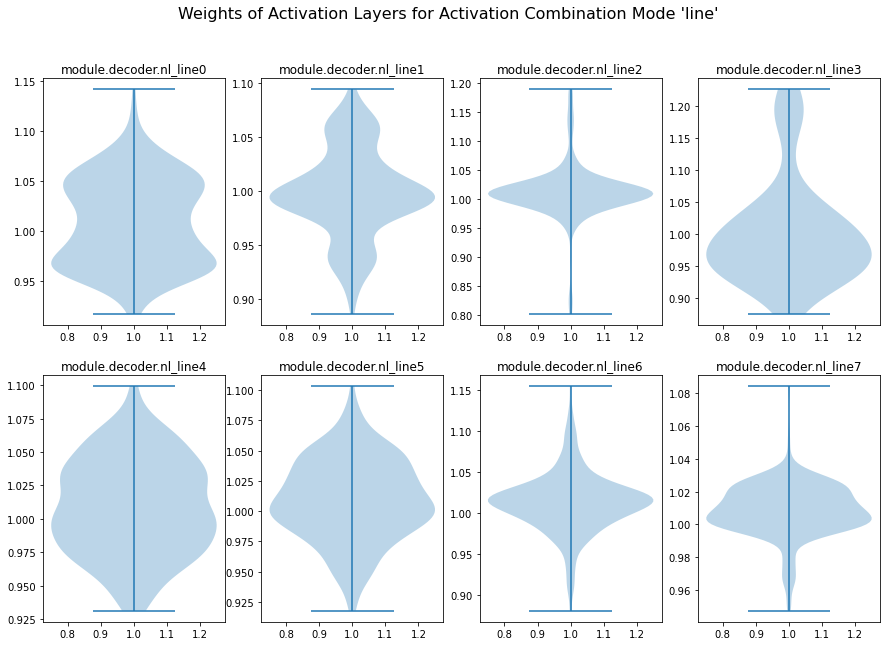

In [32]:
import torch
from matplotlib import pyplot as plt
chckpt = torch.load("/home/shared/deepsdfcomp/searches/double_nonlinearity/line/ModelParameters/latest.pth")
fig, axes = plt.subplots(2, 4, figsize=(15,10))
fig.suptitle("Weights of Activation Layers for Activation Combination Mode 'line'", fontsize=16)
for i, (k,v) in enumerate([(kk, vv) for kk, vv in chckpt["model_state_dict"].items() if "nl_line" in kk][:8]):
    ax = axes[i//4,i%4]
    ax.set_title(k)
    vplot = ax.violinplot(v.detach().cpu().numpy(), showmeans=False, showextrema=True)
plt.show()

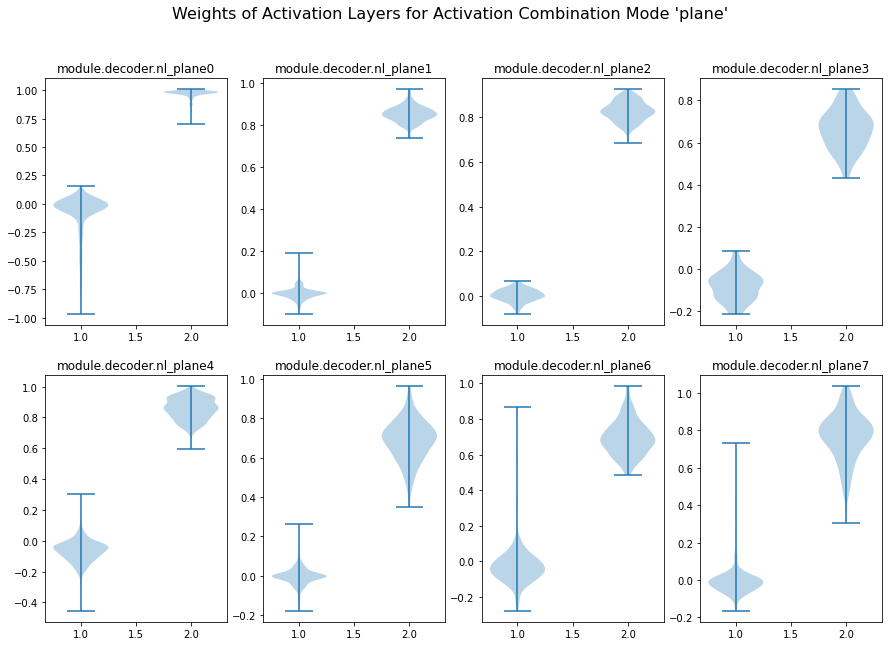

In [39]:
import torch
from matplotlib import pyplot as plt
chckpt = torch.load("/home/shared/deepsdfcomp/searches/double_nonlinearity/plane/ModelParameters/latest.pth")
fig, axes = plt.subplots(2, 4, figsize=(15,10))
fig.suptitle("Weights of Activation Layers for Activation Combination Mode 'plane'", fontsize=16)
for i, (k,v) in enumerate([(kk, vv) for kk, vv in chckpt["model_state_dict"].items() if "nl_plane" in kk][:8]):
    ax = axes[i//4,i%4]
    ax.set_title(k)
    vplot = ax.violinplot(v.detach().cpu().numpy(), showmeans=False, showextrema=True)
plt.show()

In [4]:
import pandas as pd
data = pd.read_csv("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer.csv", delimiter=';')
print(f"{data['chamfer_dist'].mean():5f}, {data['chamfer_dist'].median():5f}")

0.083380, 0.083885


In [ ]:
python reconstruct.py  --split ../../shared/deepsdfcomp/experiments/splits/sv2_planes_test.json -d ../../shared/deepsdfcomp/data/ -e ../../shared/deepsdfcomp/searches/double_nonlinearity/line --skip
python evaluate.py  --split ../../shared/deepsdfcomp/experiments/splits/sv2_planes_test.json -d ../../shared/deepsdfcomp/data/ -e ../../shared/deepsdfcomp/searches/double_nonlinearity/line -c 2000

9

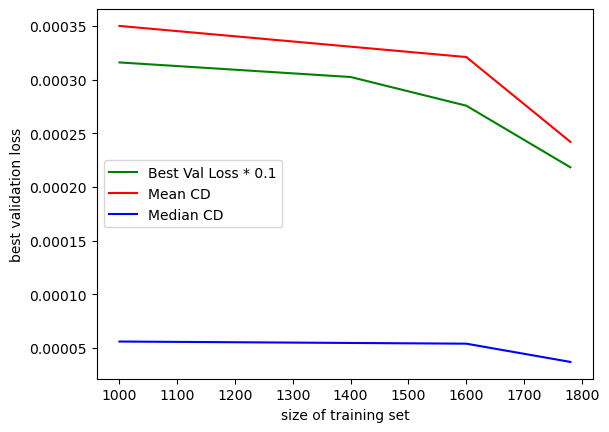

In [20]:
import numpy as np
from matplotlib import pyplot as plt
set_sizes = np.array([1780, 1600, 1400, 1200, 1000, 600, 200])
val_losses = np.array([2.183e-3, 2.757e-3, 3.024e-3, np.nan, 3.16e-3, np.nan, np.nan])
mean_CDs = np.array([0.242e-3, 0.321e-3, np.nan, np.nan, 0.350e-3, np.nan, np.nan])
median_CDs = np.array([0.037e-3, 0.054e-3, np.nan, np.nan, 0.056e-3, np.nan, np.nan])

plt.plot(set_sizes[np.isfinite(val_losses)], val_losses[np.isfinite(val_losses)]*0.1, 'g', label="Best Val Loss * 0.1")
plt.plot(set_sizes[np.isfinite(mean_CDs)], mean_CDs[np.isfinite(mean_CDs)], 'r', label="Mean CD")
plt.plot(set_sizes[np.isfinite(median_CDs)], median_CDs[np.isfinite(median_CDs)], 'b', label="Median CD")
plt.xlabel("size of training set")
plt.ylabel("best validation loss")
plt.legend()

In [21]:
import json
import random
import copy
import os
path = "/home/shared/deepsdfcomp/searches/splits/"
fname = "sv2_planes_train"
with open(os.path.join(path, fname + ".json"), 'r') as f:
    all_shapes_dict = json.load(f)
split_sizes = [1780, 1600, 1400, 1200, 1000, 800, 600, 400, 200]
for split_size in split_sizes:
    split = copy.deepcopy(all_shapes_dict)
    sampled_list = random.shuffle(split["ShapeNetV2"]["02691156"])
    split["ShapeNetV2"]["02691156"] = split["ShapeNetV2"]["02691156"][:split_size]
    with open(os.path.join(path, "subsamples", f"{fname} _{split_size}.json"), 'w+') as f:
        json.dump(split, f, indent=4)

"baseline"
	Curvature Sampling: 0 % 
	Mean CD: 1.467e-04
	Median CD: 4.003e-05
	Best Meshes:
		fdcb11fa39661f0fb08f81d66e854bfa with CD of 1.1679990103997374e-06
		df411aa240fe48d5855eb7906a7a7a04 with CD of 1.6090262747775775e-06
		d28a3cd771b2bf1e71d03b466c72ce41 with CD of 8.657810973807102e-06
	Worst Meshes:
		e3f562bd552fbb14496e2f80fb255499 with CD of 0.0101094990308915
		fc16704314dc71ee9a6e43b878d5b335 with CD of 0.00358775584537
		d8a037897d5d5b108130971b27e95927 with CD of 0.0029784317984686
"baseline"
	Curvature Sampling: 100 % 
	Mean CD: 1.569e-04
	Median CD: 4.239e-05
	Best Meshes:
		fdcb11fa39661f0fb08f81d66e854bfa with CD of 1.33504371448962e-06
		df411aa240fe48d5855eb7906a7a7a04 with CD of 1.867975110887468e-06
		e87902d01d40c71521b1ceea9c93aa79 with CD of 9.2522906176751e-06
	Worst Meshes:
		e3f562bd552fbb14496e2f80fb255499 with CD of 0.0107307604752931
		fc16704314dc71ee9a6e43b878d5b335 with CD of 0.0051297468956609
		d8a037897d5d5b108130971b27e95927 with CD of 0.0031

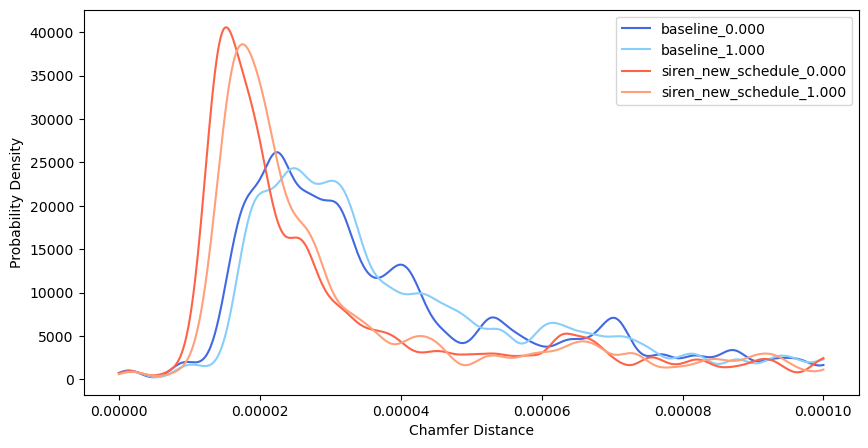

In [73]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
experiments = [
                ("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer.csv", "royalblue"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_0.200.csv", "cyan"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_0.300.csv", "cyan"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_0.500.csv", "cyan"),
                ("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_1.000.csv", "lightskyblue"),
                ("/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer.csv", "tomato"), # best
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_0.200.csv", "cyan"), # best
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_0.300.csv", "cyan"), # best
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_0.500.csv", "cyan"), # best
                ("/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_1.000.csv", "lightsalmon"), # best
                #( "/home/shared/deepsdfcomp/searches/num_shapes_search/all_shapes_batch_size_128/Evaluation/2000/chamfer.csv", "cyan"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/line_5050_ini/Evaluation/2000/chamfer.csv", "cyan"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/all_latentsize=200_width=256_lr=5e-4_int=150/Evaluation/2000/chamfer.csv", "cyan"),
            ]

plt.figure(figsize=(10,5))
for csv_path, color in experiments:
    CDs = pd.read_csv(csv_path, sep=";")
    # plt.hist(CDs, np.linspace(0, 0.002, 2000), alpha=1/len(csv_paths), label=csv_path.split("/")[-1])
    
    density = gaussian_kde(CDs["chamfer_dist"])
    density.covariance_factor = lambda : .003
    density._compute_covariance()
    x = np.linspace(0, 0.0001, 500)
    densities = density(x)
    
    # find best and worst meshes
    n = 3
    best_df= CDs.nsmallest(n, columns=["chamfer_dist"])
    worst_df= CDs.nlargest(n, columns=["chamfer_dist"])
    best_meshes = [mesh.split("/")[-1] for mesh in list(best_df["shape"])]
    best_mesh_cds = list(best_df["chamfer_dist"])
    worst_meshes = [mesh.split("/")[-1] for mesh in list(worst_df["shape"])]
    worst_mesh_cds = list(worst_df["chamfer_dist"])
    
    
    exp_name = csv_path.split("/Evaluation")[-2].split("/")[-1]
    curvature = "0.000" if "chamfer_" not in csv_path else csv_path.split("_")[-1].split(".csv")[0]
    plt.plot(x, densities, label=exp_name + "_" + curvature, color=color)
    print(f'"{exp_name}"')
    print(f"\tCurvature Sampling: {int(float(curvature) * 100)} % ")
    print(f"\tMean CD: {np.mean(CDs['chamfer_dist']):.3e}")
    print(f"\tMedian CD: {np.median(CDs['chamfer_dist']):.3e}")
    print(f"\tBest Meshes:")
    for bm, cd in zip(best_meshes, best_mesh_cds):
        print(f"\t\t{bm} with CD of {cd}")
    print(f"\tWorst Meshes:")
    for wm, cd in zip(worst_meshes, worst_mesh_cds):
        print(f"\t\t{wm} with CD of {cd}")
plt.legend()
_ = plt.xlabel("Chamfer Distance")
_ = plt.ylabel("Probability Density")


In [1]:
import trimesh
import os
import json
mesh_name = "d3b9114df1d8a3388e415c6cf89025f0"
mesh = trimesh.load(os.path.join("/mnt/hdd/ShapeNetCore.v2/02691156", mesh_name, "models/model_normalized.obj"))
with open(os.path.join("/mnt/hdd/ShapeNetCore.v2/02691156", mesh_name, "models/model_normalized.json"), 'r') as f:
    properties = json.load(f)
if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(mesh.dump())
print(mesh.vertices.min(axis=0), mesh.vertices.max(axis=0))

surface_samples = trimesh.load(os.path.join("/home/shared/deepsdfcomp/data/SurfaceSamples/ShapeNetV2/02691156", mesh_name + ".ply"))
if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(surface_samples.dump())
print(surface_samples.vertices.min(axis=0), surface_samples.vertices.max(axis=0))

reco = trimesh.load(os.path.join("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Reconstructions/2000/Meshes/ShapeNetV2/02691156", mesh_name + ".ply"))
if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(reco.dump())
print(reco.vertices.min(axis=0), reco.vertices.max(axis=0))


# samples = np.load()
# samples = samples[samples.files[0]]
# print(samples.min(axis=0), samples.max(axis=0)) 

concatenating texture: may result in visual artifacts


[-0.285115 -0.075618 -0.36779 ] [0.285099 0.19598  0.40751 ]
[-0.285115   -0.0755929  -0.36055401] [0.285099   0.19592801 0.40506601]
[-0.68753284 -0.31896016 -0.7864542 ] [0.68319559 0.30436653 0.88733315]


'pos'